# **Sentiment Analysis Using Machine Learning**

## **1 - Project Objective and description**
The objective of this project is to develop a sentiment analysis model using machine learning classification techniques. The goal is to classify tweets as either positive or negative based on their content. I will compare 3 ML models to choose the best one: Logistic Regression, Random Forest and LightGBM.

## **1.1 - Business Problem**
Understanding the sentiment of social media content generated by users can provide valuable insights for businesses. For example, it can be useful for:
- Identifying how customers feel about a product or service.
- Understanding trends and public opinions on various topics.
- Improving products and services based on user sentiment.

## **1.2 - Dataset Description**
The dataset used for this project is Sentiment140, a widely used dataset containing 1.6 million labeled tweets. Each tweet is annotated as:
- 0: Negative sentiment
- 4: Positive sentiment (which we convert to 1 for binary classification)

To make the dataset more manageable, I will extract a balanced subset of 200,000 tweets (100K positive and 100K negative).

## **1.3 - Project Workflow**
The project consists of the following steps:
1. Data Preprocessing: Loading and preparing the dataset.
2. Exploratory Data Analysis (EDA): Understanding data distribution and key insights.
3. Feature Engineering: Converting text into numerical representations.
4. Model Training: Train the three selected models.
5. Hyperparameter Tuning: Optimizing model performance.
6. Evaluation & Interpretation: Assessing model accuracy and performance.
7- Model saving.

This structured approach will help us build a reliable sentiment analysis model that can classify tweets effectively.


## **Step 1: Data Preprocessing - Loading and Preparing the Dataset**
**Objective of Data Preprocessing**

Data preprocessing is a crucial step in any machine learning pipeline. The goal is to clean and prepare the dataset so that it can be efficiently used for analysis and model training. In this step, we will:

1-Load the dataset.

2-Reduce the dataset size to 200K tweets.

3-Remove unnecessary columns and transform some of them.

4-Handle missing or duplicate values.

5-Normalize labels (0 for negative, 1 for positive).

6-Save the cleaned dataset.

In [4]:
#Import all the necessary libraries, packages and modules
import os
import sys
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.utils import resample
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
import seaborn as sns
from collections import Counter
import re
import warnings
warnings.filterwarnings("ignore")

# Add the utils_1 directory to the system path
sys.path.append(os.path.abspath(os.path.join('..', 'utils')))

# Import the functions from utils.py
import utils


from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import nltk
from nltk.corpus import stopwords, wordnet
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer, WordNetLemmatizer

In [60]:
from gensim.models import Word2Vec
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
from xgboost import XGBClassifier


In [42]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint


In [5]:
# Load dataset from local file
file_path = "../complete_data/training.1600000.processed.noemoticon.csv"

# Select the important columns and drop the query and user column as we will not be using them
df = pd.read_csv(file_path, encoding="latin-1", header=None, usecols=[0, 1, 2, 5], names=["sentiment", "tweet_id", "date", "text"])

# Mapping sentiment labels (0 = negative, 4 = positive) to (0 = negative,1 = positive)
df['sentiment'] = df['sentiment'].replace({4: 1})

# Convert 'date' column to datetime format
df['date'] = pd.to_datetime(df['date'], errors='coerce')

# Extract useful features
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day_of_week'] = df['date'].dt.dayofweek  # Monday=0, Sunday=6
df['hour'] = df['date'].dt.hour

# Sampling 100K positive and 100K negative to maintain balance
negative = df[df['sentiment'] == 0]
positive = df[df['sentiment'] == 1]
negative_sample = resample(negative, n_samples=100000, random_state=42)
positive_sample = resample(positive, n_samples=100000, random_state=42)

# Combine and shuffle the dataset
sampled_df = pd.concat([negative_sample, positive_sample]).sample(frac=1, random_state=42).reset_index(drop=True)

# Check for missing values
missing_values = sampled_df.isnull().sum()
print("Missing values per column:\n", missing_values)

# Drop any rows with missing values (if any)
sampled_df.dropna(inplace=True)

# Check for duplicate tweets
duplicate_count = sampled_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicate_count}")

# Remove duplicates if necessary
sampled_df.drop_duplicates(inplace=True)

# Verify sentiment distribution
print("Sentiment distribution:")
print(sampled_df['sentiment'].value_counts())

# Ensure sentiment labels are binary (0 = Negative, 1 = Positive)
sampled_df['sentiment'] = sampled_df['sentiment'].astype(int)

# Save the cleaned dataset
os.makedirs("../complete_data", exist_ok=True)
sampled_df.to_csv("../complete_data/sentiment140_cleaned.csv", index=False)

print("Cleaned dataset saved successfully!")


Missing values per column:
 sentiment      0
tweet_id       0
date           0
text           0
year           0
month          0
day_of_week    0
hour           0
dtype: int64
Number of duplicate rows: 11868
Sentiment distribution:
sentiment
1    94066
0    94066
Name: count, dtype: int64
Cleaned dataset saved successfully!


In [8]:
# Dataset inspection:
sampled_df.head(5)

,sentiment,tweet_id,date,text,year,month,day_of_week,hour
0,1,1969922949,2009-05-30 01:44:48,@Vh1Frenchy:heyyyyy you how's stripping makin...,2009,5,5,1
1,0,2058345523,2009-06-06 14:45:16,Argh! I just missed the Yonge &amp; Dundas gui...,2009,6,5,14
2,1,1694585995,2009-05-04 03:17:29,@perpetualspiral I LOVE pb &amp; banana sandwi...,2009,5,0,3
3,0,1822384818,2009-05-16 19:27:20,fell off a chair while trying to set up for th...,2009,5,5,19
4,0,1962583315,2009-05-29 11:16:19,Got 2 get ready 4 work would rather be fishing!,2009,5,4,11


In [9]:
# Dataset inspection:
sampled_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 188132 entries, 0 to 199999
Data columns (total 8 columns):
 #   Column       Non-Null Count   Dtype         
---  ------       --------------   -----         
 0   sentiment    188132 non-null  int64         
 1   tweet_id     188132 non-null  int64         
 2   date         188132 non-null  datetime64[ns]
 3   text         188132 non-null  object        
 4   year         188132 non-null  int32         
 5   month        188132 non-null  int32         
 6   day_of_week  188132 non-null  int32         
 7   hour         188132 non-null  int32         
dtypes: datetime64[ns](1), int32(4), int64(2), object(1)
memory usage: 10.0+ MB


## **Step 2: Exploratory Data Analysis (EDA)**
In this step I will analyse and visualize the dataset to understand its structure, feature relationships, etc.
I will also clean it further if necessary, and prepare it for model training.

I will perform the following tasks:

1-Check for basic statistics: Get an overview of the dataset.

2-Visualize the distribution of sentiments: Check the balance of positive and negative tweets.

3-Analyze the text data: Look at the length of tweets, common words, etc.

4-Analyze time-related features: Check for trends over time based on the year, month, day_of_week, and hour features.

Basic Statistics of the dataset:


,sentiment,tweet_id,date,year,month,day_of_week,hour
count,188132.000000,1.881320e+05,188132,188132.0,188132.000000,188132.000000,188132.000000
mean,0.500000,1.998539e+09,2009-05-31 06:44:09.080406272,2009.0,5.514894,3.324527,10.951911
min,0.000000,1.467811e+09,2009-04-06 22:20:00,2009.0,4.000000,0.000000,0.000000
25%,0.000000,1.956797e+09,2009-05-28 22:42:46.500000,2009.0,5.000000,1.000000,5.000000
50%,0.500000,2.002112e+09,2009-06-02 03:10:52,2009.0,6.000000,4.000000,10.000000
75%,1.000000,2.177124e+09,2009-06-15 05:30:02.750000128,2009.0,6.000000,5.000000,17.000000
max,1.000000,2.329204e+09,2009-06-25 10:28:25,2009.0,6.000000,6.000000,23.000000
std,0.500001,1.939620e+08,NaN,0.0,0.612113,2.248964,7.221241


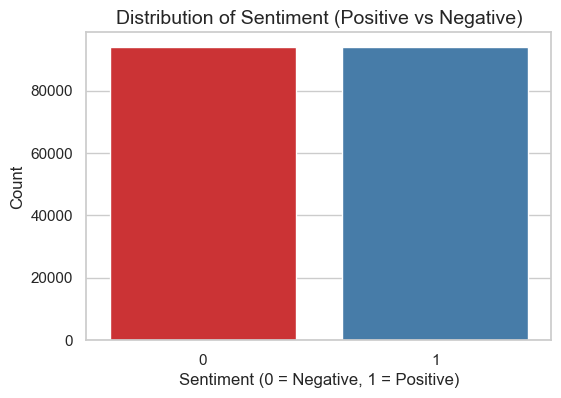

In [10]:
# Set plot style
sns.set(style="whitegrid")

# Display basic statistics
print("Basic Statistics of the dataset:")
display(sampled_df.describe())

# 1. Sentiment Distribution, as we have prepared a balanced dataset we will have equal number of positive and negative tweets
plt.figure(figsize=(6, 4))
sns.countplot(x='sentiment', data=sampled_df, palette="Set1")
plt.title('Distribution of Sentiment (Positive vs Negative)', fontsize=14)
plt.xlabel('Sentiment (0 = Negative, 1 = Positive)')
plt.ylabel('Count')
plt.show()

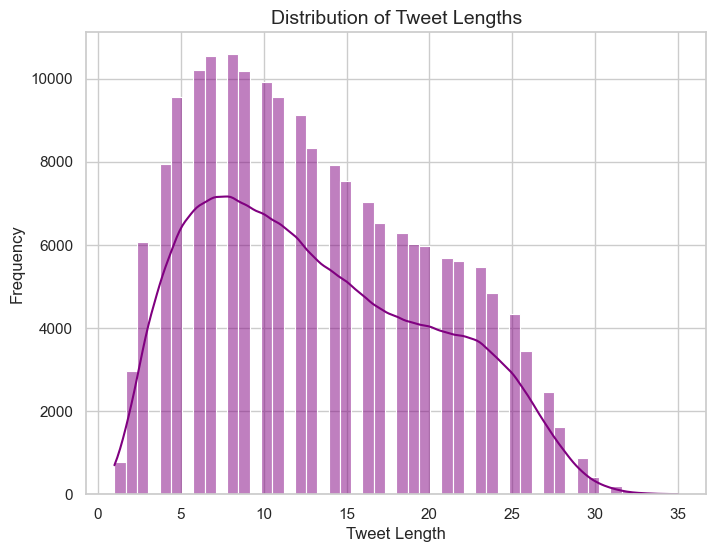

In [11]:
# 2. Tweet Length Analysis (Length of Tweets in terms of words as there is a character limitation on Twitter,
# it would be more interesting to check the lenght in terms of words)
sampled_df['text_length'] = sampled_df['text'].apply(lambda x: len(str(x).split()))

# Visualizing Tweet Length Distribution
plt.figure(figsize=(8, 6))
sns.histplot(sampled_df['text_length'], bins=50, kde=True, color="purple")
plt.title('Distribution of Tweet Lengths', fontsize=14)
plt.xlabel('Tweet Length')
plt.ylabel('Frequency')
plt.show()

The shape of the chart suggest shorter tweets are more commong than long ones. The tweets lenght follow a normal distribution, with most tweets having a length around the average, and fewer tweets being very short or very long.

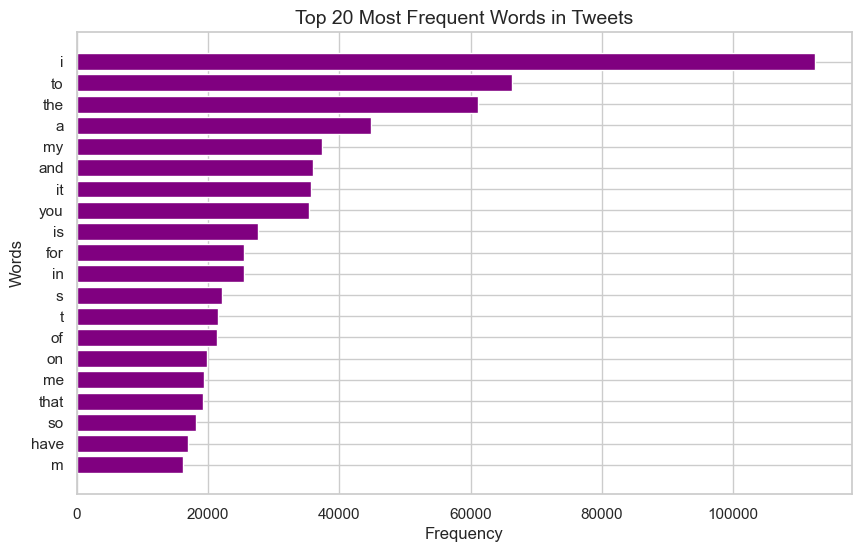

In [12]:
# 3. Word Frequency Plot
# Function to clean and tokenize text
def clean_text(text):
    # Remove non-alphabetic characters and split into words
    words = re.findall(r'\b\w+\b', str(text).lower())
    return words

# Combine all tweets into a single string and clean them
all_words = []
for tweet in sampled_df['text']:
    all_words.extend(clean_text(tweet))

# Count word frequencies
word_counts = Counter(all_words)

# Get the 20 most common words
common_words = word_counts.most_common(20)

# Unzip the list of common words and their counts
words, counts = zip(*common_words)

# Plot the 20 most common words
plt.figure(figsize=(10, 6))
plt.barh(words, counts, color="purple")
plt.xlabel('Frequency')
plt.ylabel('Words')
plt.title('Top 20 Most Frequent Words in Tweets', fontsize=14)
plt.gca().invert_yaxis()  # Invert y-axis to have the most frequent word at the top
plt.show()

The above chart is not really helpful as all of the words are prepositons, pronouns, isolated letters, etc. So we do not extract much information from this chart. This type of stopwords will be handled later in the notebook.

In the following plots we will explore the relationship between the sentiment and the date information that we have to check if we can find any interesting pattern.

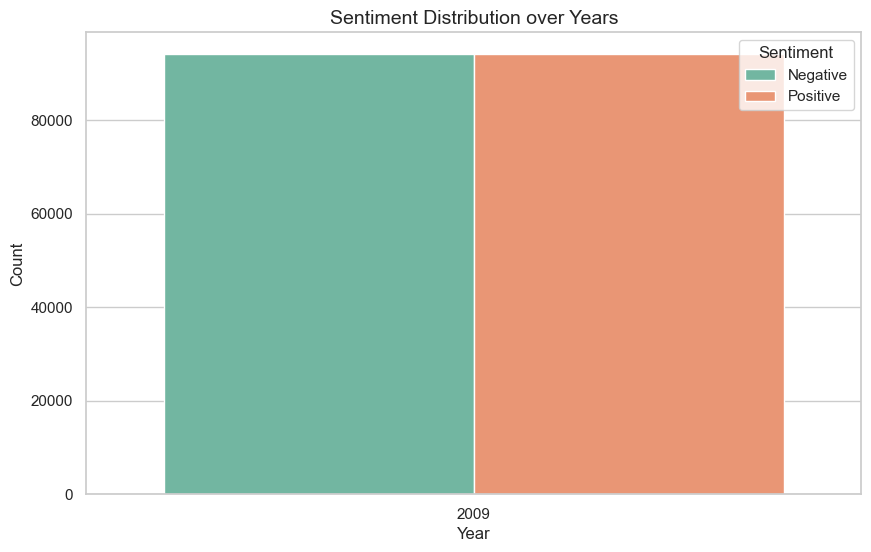

In [13]:
# 4. Sentiment vs. Year Analysis
plt.figure(figsize=(10, 6))
sns.countplot(x='year', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution over Years', fontsize=14)
plt.xlabel('Year')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

Not very helpful as we only have data from one year (2009).

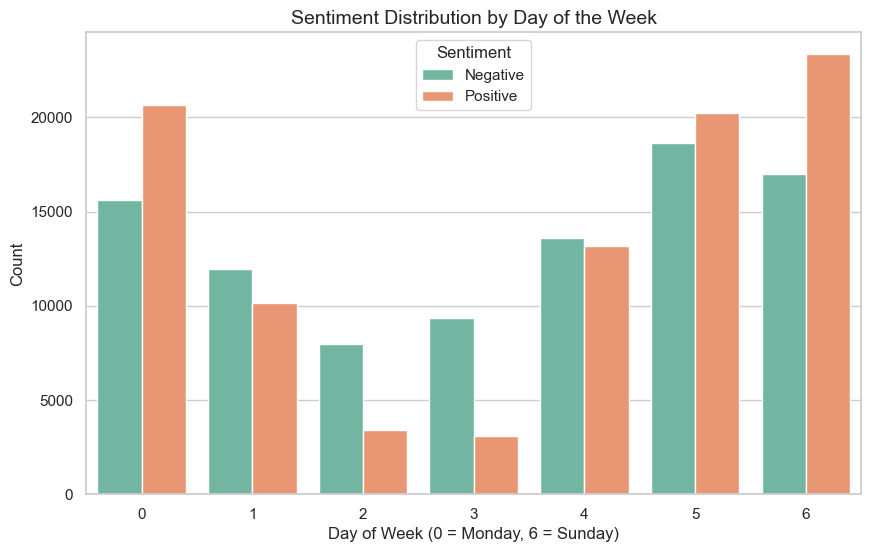

In [14]:
# 5. Sentiment vs. Day of the Week
plt.figure(figsize=(10, 6))
sns.countplot(x='day_of_week', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution by Day of the Week', fontsize=14)
plt.xlabel('Day of Week (0 = Monday, 6 = Sunday)')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

We can see an interesting figure here, first we can see that most of the tweets from the dataset were posted at the beginning of the week, on Monday and at the end of the week, specially during the weekend and more importantly, we can see that the positive tweets tend to appear on Monday, Saturday and Sunday; while the negative ones tend to appear during week days, between Tuesday and Friday.

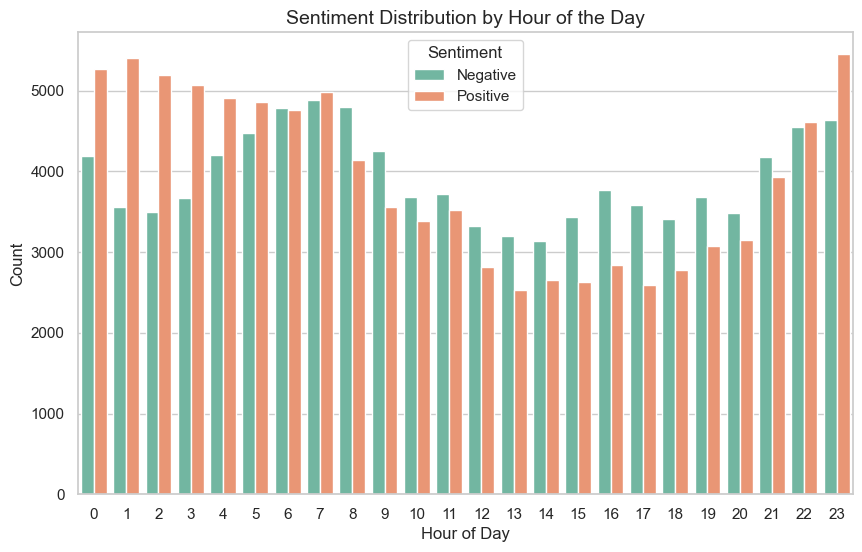

In [15]:
# 6. Sentiment vs. Hour of the Day
plt.figure(figsize=(10, 6))
sns.countplot(x='hour', hue='sentiment', data=sampled_df, palette="Set2")
plt.title('Sentiment Distribution by Hour of the Day', fontsize=14)
plt.xlabel('Hour of Day')
plt.ylabel('Count')
plt.legend(title="Sentiment", labels=["Negative", "Positive"])
plt.show()

In this plot, we can also see another interesting figure. When it comes to the hours of the day, the tweets are mostly located between midnight and early morning and during the night, that means that most of the tweets were posted outside typical working hours.

Focusing on the sentiment of the tweet, we can see that the positive ones were posted mainly during the night, from 0 to 7 and between 22 and 23; while the negative ones are gathered during working hours, between 8 and late afternoon, 21.

## **Step 3: Feature Engineering**

In this step I will prepare the textual data for the ML model. These are the steps that I will implement:

1-Text Cleaning: Convert text to lowercase, remove punctuation, special characters, and stopwords.

2-Tokenization: Split text into individual words (tokens).

3-Removing Stopwords: Eliminate common words that do not contribute to sentiment (e.g., "the", "is", "and").

4-Stemming/Lemmatization: Reduce words to their base form (e.g., "running" → "run").

5-Word Embeddings: Use pre-trained word embeddings (Word2Vec) for improved text representation.


In [30]:
nltk.download('averaged_perceptron_tagger_eng')

# Ensure necessary NLTK resources are downloaded
nltk.download("stopwords")
nltk.download("punkt")
nltk.download("wordnet")

# Initialize stemmer and lemmatizer
stemmer = PorterStemmer()
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

# Function to get POS tags for better lemmatization
def get_wordnet_pos(word):
    """Map POS tag to first character used by WordNetLemmatizer"""
    from nltk.corpus import wordnet
    from nltk.tag import pos_tag
    
    tag = pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ, "N": wordnet.NOUN, "V": wordnet.VERB, "R": wordnet.ADV}
    return tag_dict.get(tag, wordnet.NOUN)  # Default to noun if unknown

# Updated text preprocessing function
def preprocess_text(text, use_stemming=False, use_lemmatization=True):
    # Remove non-alphabetic characters and convert to lowercase
    words = re.findall(r'\b\w+\b', str(text).lower())

    # Remove stopwords
    words = [word for word in words if word not in stop_words]

    # Apply stemming or lemmatization
    if use_stemming:
        words = [stemmer.stem(word) for word in words]
    elif use_lemmatization:
        words = [lemmatizer.lemmatize(word, get_wordnet_pos(word)) for word in words]

    return " ".join(words)

# Apply preprocessing to the dataset
sampled_df["clean_text"] = sampled_df["text"].apply(lambda x: preprocess_text(x, use_stemming=False, use_lemmatization=True))

# Display some samples
print(sampled_df[["text", "clean_text"]].head())

[nltk_data] Downloading package averaged_perceptron_tagger_eng to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger_eng is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/angelaft/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/angelaft/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                                text  \
0  @Vh1Frenchy:heyyyyy you  how's stripping makin...   
1  Argh! I just missed the Yonge &amp; Dundas gui...   
2  @perpetualspiral I LOVE pb &amp; banana sandwi...   
3  fell off a chair while trying to set up for th...   
4   Got 2 get ready 4 work  would rather be fishing!   

                                          clean_text  
0                      vh1frenchy heyyyyy strip make  
1              argh miss yonge amp dundas guitar jam  
2  perpetualspiral love pb amp banana sandwich st...  
3  fell chair try set thespian initiation really ...  
4        get 2 get ready 4 work would rather fishing  


In [24]:
# Feature: Number of hashtags
sampled_df["num_hashtags"] = sampled_df["text"].apply(lambda x: x.count("#"))

# Feature: Number of mentions
sampled_df["num_mentions"] = sampled_df["text"].apply(lambda x: x.count("@"))

# Feature: Number of links
sampled_df["num_links"] = sampled_df["text"].apply(lambda x: len(re.findall(r"http\S+", x)))

# Combine these new features into the dataset
feature_columns = ["text_length", "num_hashtags", "num_mentions", "num_links"]
X_additional = sampled_df[feature_columns]

# Concatenate additional features with TF-IDF features
X_final = np.hstack((X_tfidf.toarray(), X_additional.to_numpy()))

# Display the shape
print("Final Feature Matrix Shape:", X_final.shape)


Final Feature Matrix Shape: (188132, 5004)


In [ ]:
# Tokenize each tweet into a list of words
sampled_df["tokenized_text"] = sampled_df["clean_text"].apply(lambda x: x.split())

# Train a Word2Vec model
word2vec_model = Word2Vec(sentences=sampled_df["tokenized_text"], vector_size=100, window=5, min_count=2, workers=4)

# Function to get tweet embeddings
def get_tweet_embedding(words, model):
    vectors = [model.wv[word] for word in words if word in model.wv]
    return sum(vectors) / len(vectors) if vectors else np.zeros(model.vector_size)

# Apply embeddings to each tweet
X_embeddings = np.array([get_tweet_embedding(words, word2vec_model) for words in sampled_df["tokenized_text"]])

# Display shape of embedding matrix
print("Word2Vec Embedding Shape:", X_embeddings.shape)

# Combine additional features (hashtags, mentions, links) with Word2Vec embeddings
feature_columns = ["text_length", "num_hashtags", "num_mentions", "num_links"]
X_additional = sampled_df[feature_columns]

# Concatenate Word2Vec embeddings with additional features
X_final = np.hstack((X_embeddings, X_additional.to_numpy()))

# Display the shape of the final feature matrix
print("Final Feature Matrix Shape:", X_final.shape)


Word2Vec Embedding Shape: (188132, 100)
Final Feature Matrix Shape: (188132, 104)


## Step 4 **Model Training**

In this step I will train the three ML models Logistic Regression, Random Forest and LightGBM. I will:

1-Split the data into training and testing set. I will use the division 80% train and 20% test.

2-Train the models on the training set and evaluate them.

In [34]:

# Split the features (X) and target (y)
X = X_final  # Features (TF-IDF + Additional features or Word2Vec)
y = sampled_df['sentiment']  # Target labels (sentiment)

# Split into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("Training set size:", X_train.shape)
print("Test set size:", X_test.shape)


Training set size: (150505, 104)
Test set size: (37627, 104)


In [36]:
# Initialize Logistic Regression model
lr_model = LogisticRegression(max_iter=1000)

# Train the model on the training set
lr_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the model
print("Logistic Regression Accuracy:", accuracy_score(y_test, y_pred_lr))
print("\nLogistic Regression Classification Report:\n", classification_report(y_test, y_pred_lr))
print("\nLogistic Regression Confusion Matrix:\n", confusion_matrix(y_test, y_pred_lr))


Logistic Regression Accuracy: 0.7334626730805007

Logistic Regression Classification Report:
               precision    recall  f1-score   support

           0       0.74      0.72      0.73     18817
           1       0.73      0.75      0.74     18810

    accuracy                           0.73     37627
   macro avg       0.73      0.73      0.73     37627
weighted avg       0.73      0.73      0.73     37627


Logistic Regression Confusion Matrix:
 [[13520  5297]
 [ 4732 14078]]


In [38]:
# Initialize Random Forest model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)

# Train the model on the training set
rf_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the model
print("Random Forest Accuracy:", accuracy_score(y_test, y_pred_rf))
print("\nRandom Forest Classification Report:\n", classification_report(y_test, y_pred_rf))
print("\nRandom Forest Confusion Matrix:\n", confusion_matrix(y_test, y_pred_rf))


Random Forest Accuracy: 0.7275360778164616

Random Forest Classification Report:
               precision    recall  f1-score   support

           0       0.73      0.73      0.73     18817
           1       0.73      0.72      0.73     18810

    accuracy                           0.73     37627
   macro avg       0.73      0.73      0.73     37627
weighted avg       0.73      0.73      0.73     37627


Random Forest Confusion Matrix:
 [[13739  5078]
 [ 5174 13636]]


In [53]:
# Initialize XGBoost classifier
xgb_model = xgb.XGBClassifier(
    objective='binary:logistic', 
    eval_metric='logloss', 
    use_label_encoder=False,
    n_estimators=100,  # Number of boosting rounds
    max_depth=6,  # Maximum depth of a tree
    learning_rate=0.1,  # Step size shrinkage
    subsample=0.8,  # Fraction of samples to be used for training each tree
    colsample_bytree=0.8  # Fraction of features to be used for training each tree
)

# Train the model
xgb_model.fit(X_train, y_train)

# Predictions
y_pred_xgb = xgb_model.predict(X_test)

# Evaluate performance
accuracy_xgb = accuracy_score(y_test, y_pred_xgb)
print("XGBoost Accuracy:", accuracy_xgb)

print("\nXGBoost Classification Report:")
print(classification_report(y_test, y_pred_xgb))

print("\nXGBoost Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_xgb))


XGBoost Accuracy: 0.736200069099317

XGBoost Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     18817
           1       0.73      0.75      0.74     18810

    accuracy                           0.74     37627
   macro avg       0.74      0.74      0.74     37627
weighted avg       0.74      0.74      0.74     37627


XGBoost Confusion Matrix:
[[13603  5214]
 [ 4712 14098]]


Evaluation results:

1-The 3 models achieve an accuracy around 73%. Logistic Regression has a slightly higher accuracy (73.35%) compared to Random Forest (72.75%), while XGBoost is the best model with 0,74% accuracy.

2-Precision and recall: the logistic regression model does a better job when identifying positive tweets, the random forest model has a more balanced performance between the two classes and the XGBoost model has the highest recall for class 1.

3-Confusion matrix: Logistic Regression has fewer false negatives (4,732) compared to Random Forest (5,174), which could mean it is better at predicting positive sentiments. Both models have a similar number of false positives (around 5,000), which indicates that both models tend to misclassify negative tweets as positive. The XGBoost model has less false negatives than the other models.

4- F1-Score: The 3 models have similar F1-scores around 0.73-0.74 for both classes, meaning their balance between precision and recall is fairly similar.

## **Step 5- Hyperparameter tuning**

In this step I will modify the hyperparameters of the 3 models to improve their performance. I will use GridSearchCV for the logistic regression model and RandomizedSearchCV for the Random Forest and XGBoost models.

In [40]:
# Logistic Regression hyperparameters grid
param_grid_lr = {
    'C': [0.01, 0.1, 1, 10, 100],  # Regularization strength
    'solver': ['liblinear', 'lbfgs'],  # Solvers
    'penalty': ['l1', 'l2']  # Regularization methods
}

# Initialize Logistic Regression model
logreg = LogisticRegression()

# Initialize GridSearchCV for Logistic Regression
grid_search_lr = GridSearchCV(estimator=logreg, param_grid=param_grid_lr, 
                              cv=3, n_jobs=-1, verbose=2, scoring='accuracy')

# Fit GridSearchCV on the training data
grid_search_lr.fit(X_train, y_train)

# Best parameters from GridSearchCV
print("Best Hyperparameters for Logistic Regression:", grid_search_lr.best_params_)

# Evaluate the model on the test set
best_logreg_model = grid_search_lr.best_estimator_
y_pred_lr = best_logreg_model.predict(X_test)

# Classification report for Logistic Regression
print("\nLogistic Regression Hyperparameter Tuned Classification Report:")
print(classification_report(y_test, y_pred_lr))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.4s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.5s
[CV] END ...................C=0.01, penalty=l1, solver=lbfgs; total time=   0.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://sciki

[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   3.9s
[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   4.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   8.0s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   7.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ...................C=0.01, penalty=l2, solver=lbfgs; total time=   4.0s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.3s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ...............C=0.01, penalty=l2, solver=liblinear; total time=   9.2s
[CV] END ....................C=0.1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  10.4s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  12.7s
[CV] END ...............C=0.01, penalty=l1, solver=liblinear; total time=  13.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=0.1, penalty=l2, solver=lbfgs; total time=   3.5s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  11.6s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  13.3s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ......................C=1, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ................C=0.1, penalty=l2, solver=liblinear; total time=  13.1s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  17.6s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  19.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   3.3s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   3.3s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=  47.8s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=  44.6s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ......................C=1, penalty=l2, solver=lbfgs; total time=   3.5s
[CV] END ..................C=1, penalty=l2, solver=liblinear; total time=  18.1s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END .....................C=10, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ................C=0.1, penalty=l1, solver=liblinear; total time=  57.9s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  24.5s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  24.9s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.8s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   3.9s
[CV] END .................C=10, penalty=l2, solver=liblinear; total time=  18.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END .....................C=10, penalty=l2, solver=lbfgs; total time=   4.3s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time= 1.6min
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time= 1.7min
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ....................C=100, penalty=l1, solver=lbfgs; total time=   0.1s
[CV] END ..................C=1, penalty=l1, solver=liblinear; total time= 1.9min
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=  24.8s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=  20.5s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.4s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.2s


/Library/Frameworks/Python.framework/Versions/3.12/lib/python3.12/site-packages/sklearn/linear_model/_logistic.py:465: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


[CV] END ....................C=100, penalty=l2, solver=lbfgs; total time=   3.3s
[CV] END ................C=100, penalty=l2, solver=liblinear; total time=  22.8s
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.1min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.5min
[CV] END .................C=10, penalty=l1, solver=liblinear; total time= 2.6min
[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 2.0min
[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 1.8min
[CV] END ................C=100, penalty=l1, solver=liblinear; total time= 2.1min
Best Hyperparameters for Logistic Regression: {'C': 1, 'penalty': 'l2', 'solver': 'liblinear'}

Logistic Regression Hyperparameter Tuned Classification Report:
              precision    recall  f1-score   support

           0       0.74      0.72      0.73     18817
           1       0.73      0.75      0.74     18810

    accuracy                

In [43]:
# Define the hyperparameter space
param_dist = {
    "n_estimators": randint(50, 150),  # Randomly pick values between 50 and 150
    "max_depth": randint(10, 30),  # Random depth range
    "min_samples_split": randint(2, 10),
    "min_samples_leaf": randint(1, 5),
    "bootstrap": [True, False],  # Try both bootstrap settings
}

# Initialize the Random Forest model
rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

# Use RandomizedSearchCV
random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_dist,
    n_iter=20,  # Randomly try 20 different hyperparameter sets
    cv=3,  # 3-fold cross-validation to speed up
    verbose=2,
    random_state=42,
    n_jobs=-1,  # Use all available processors
)

# Fit the model
random_search.fit(X_train, y_train)

# Best parameters
print("Best Hyperparameters for Random Forest:", random_search.best_params_)

# Evaluate the best model
best_rf_model = random_search.best_estimator_
y_pred_rf_tuned = best_rf_model.predict(X_test)

# Print classification report
print("\nRandom Forest Hyperparameter Tuned Classification Report:")
print(classification_report(y_test, y_pred_rf_tuned))

# Confusion Matrix
print("\nRandom Forest Confusion Matrix:")
print(confusion_matrix(y_test, y_pred_rf_tuned))


Fitting 3 folds for each of 20 candidates, totalling 60 fits
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=136; total time= 2.8min
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=136; total time= 2.8min
[CV] END bootstrap=True, max_depth=16, min_samples_leaf=2, min_samples_split=4, n_estimators=136; total time= 2.8min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=1, min_samples_split=8, n_estimators=121; total time= 2.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=1, min_samples_split=8, n_estimators=121; total time= 2.9min
[CV] END bootstrap=True, max_depth=29, min_samples_leaf=1, min_samples_split=8, n_estimators=121; total time= 2.9min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=149; total time= 3.2min
[CV] END bootstrap=True, max_depth=20, min_samples_leaf=4, min_samples_split=6, n_estimators=149; total time= 3.2min
[CV

In [6]:
import os
# Create the sample_dataset directory if it doesn't exist
sample_dir = os.path.join("..", "sample_dataset")
os.makedirs(sample_dir, exist_ok=True)

# Determine how many samples we can include while staying under 5MB
# Check the size of our current dataframe
def estimate_size_mb(df):
    # Estimate the size in memory
    size_bytes = df.memory_usage(deep=True).sum()
    size_mb = size_bytes / (1024 * 1024)
    return size_mb

# Start with a small sample and check the size
sample_size = 5000 
sample_df = sampled_df.sample(n=sample_size, random_state=42)

# Check estimated size
estimated_size = estimate_size_mb(sample_df)
print(f"Estimated size of {sample_size} samples: {estimated_size:.2f} MB")

# If it's still under 5MB, we can try to increase the sample size
while estimated_size < 4.0:  # Aim for under 4MB to be safe
    sample_size += 1000
    sample_df = sampled_df.sample(n=sample_size, random_state=42)
    estimated_size = estimate_size_mb(sample_df)
    print(f"Increased to {sample_size} samples: {estimated_size:.2f} MB")
    
    # Safety check to avoid infinite loop
    if sample_size >= 20000:
        break

# Make sure we have a balanced dataset with equal numbers of positive and negative samples
final_sample_size_per_class = sample_size // 2
positive_samples = sampled_df[sampled_df['sentiment'] == 1].sample(n=final_sample_size_per_class, random_state=42)
negative_samples = sampled_df[sampled_df['sentiment'] == 0].sample(n=final_sample_size_per_class, random_state=42)

# Combine and shuffle
final_sample_df = pd.concat([positive_samples, negative_samples]).sample(frac=1, random_state=42).reset_index(drop=True)

# Save the sample dataset
sample_file_path = os.path.join(sample_dir, "sentiment140_sample_FINAL.csv")
final_sample_df.to_csv(sample_file_path, index=False)

# Verify the file size
file_size_bytes = os.path.getsize(sample_file_path)
file_size_mb = file_size_bytes / (1024 * 1024)
print(f"Sample dataset saved as '{sample_file_path}'")
print(f"File size: {file_size_mb:.2f} MB")

# Print sample info
print(f"Number of samples: {len(final_sample_df)}")
print(f"Sentiment distribution:\n{final_sample_df['sentiment'].value_counts()}")

Estimated size of 5000 samples: 0.82 MB
Increased to 6000 samples: 0.99 MB
Increased to 7000 samples: 1.15 MB
Increased to 8000 samples: 1.31 MB
Increased to 9000 samples: 1.48 MB
Increased to 10000 samples: 1.64 MB
Increased to 11000 samples: 1.81 MB
Increased to 12000 samples: 1.97 MB
Increased to 13000 samples: 2.14 MB
Increased to 14000 samples: 2.30 MB
Increased to 15000 samples: 2.46 MB
Increased to 16000 samples: 2.63 MB
Increased to 17000 samples: 2.79 MB
Increased to 18000 samples: 2.96 MB
Increased to 19000 samples: 3.12 MB
Increased to 20000 samples: 3.28 MB
Sample dataset saved as '../sample_dataset/sentiment140_sample_FINAL.csv'
File size: 2.29 MB
Number of samples: 20000
Sentiment distribution:
sentiment
0    10000
1    10000
Name: count, dtype: int64
